In [15]:
import os
# os.chdir("../")
%env CUDA_VISIBLE_DEVICES=1
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=1


In [131]:
import re
import time as ti
import numpy as np                                                              
import pprint
import matplotlib.pyplot as plt
import tensorflow as tf                                                         
import data.data_selector as ds                                                   
import utils.plot_functions as pf                                               
import analysis.analysis_picker as ap
from utils.logger import Logger

In [132]:
class analysis_params():
    model_type = "ica_subspace"
    model_name = "ica_subspace"
    overwrite_analysis = False
    version = "0.0"

analysis_params.model_dir = (os.path.expanduser("~")+"/Work/Projects/"+analysis_params.model_name)
log_file = (analysis_params.model_dir+"/logfiles/"+analysis_params.model_name+"_v"+analysis_params.version+".log")

In [133]:
logger = Logger(filename=None)
log_text = logger.load_file(log_file)
model_params = logger.read_params(log_text)[0]
model_schedule = logger.read_schedule(log_text)

In [134]:
logger.__dir__()

['filename',
 'log_to_file',
 'file_obj',
 '__module__',
 '__init__',
 'js_dumpstring',
 'log_trainable_variables',
 'log_params',
 'log_schedule',
 'log_info',
 'load_file',
 'read_js',
 'read_trainable_variables',
 'read_params',
 'read_schedule',
 'read_stats',
 '__del__',
 '__dict__',
 '__weakref__',
 '__doc__',
 '__repr__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__new__',
 '__reduce_ex__',
 '__reduce__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

In [135]:
pp = pprint.PrettyPrinter(indent=0)
print("PARAMS")
pp.pprint(model_params.__dict__)
print()
print("SCHEUDLE")
pp.pprint(model_schedule)

PARAMS
{'batch_size': 1,
'center_data': True,
'contrast_normalize': False,
'cp_int': 1000,
'cp_latest_filename': 'latest_checkpoint_v0.0',
'cp_load': False,
'cp_load_dir': '/home/ryanchan/Work/Projects/pretrain/checkpoints/',
'cp_load_latest_filename': 'latest_checkpoint_v0.0',
'cp_load_name': 'pretrain',
'cp_load_step': None,
'cp_load_var': ['w_synth'],
'cp_load_ver': '0.0',
'cp_save_dir': '/home/ryanchan/Work/Projects/ica_subspace/checkpoints/',
'data_dir': '/home/ryanchan/datasets/vanHateren/',
'data_shape': [256],
'data_type': 'vanHateren',
'device': '/gpu:0',
'disp_dir': '/home/ryanchan/Work/Projects/ica_subspace/vis/',
'eps': 1e-12,
'extract_patches': True,
'gen_plot_int': 1000,
'group_sizes': None,
'log_dir': '/home/ryanchan/Work/Projects/ica_subspace/logfiles/',
'log_int': 100,
'log_to_file': True,
'lpf_cutoff': 0.7,
'lpf_data': False,
'max_cp_to_keep': 1,
'model_name': 'ica_subspace',
'model_out_dir': '/home/ryanchan/Work/Projects/ica_subspace',
'model_type': 'ica_subspace',
'

In [136]:
stats = logger.read_stats(log_text)
pp.pprint(stats.keys())

dict_keys(['a_fraction_active', 'a_max_mean_min', 'batch_step', 'global_batch_index', 'global_step', 'group_index', 'group_sizes', 'latent_vars', 'number_of_batch_steps', 'schedule_index', 'w_analy', 'w_synth', 'w_synth_grad_max_mean_min', 'x_hat_max_mean_min', 'x_max_mean_min', 'z_fraction_active', 'z_max_mean_min'])


In [143]:
w_analy = np.array(stats["w_analy"])
w_synth = np.array(stats["w_synth"])

In [146]:
def plot_weight(w, step, nrows=16, ncols=16):
    w = np.array(w)[step, : ,:]
    fig, ax = plt.subplots(nrows, nrows, figsize=(20, 20))
    vec_i = 0
    for i in range(nrows):
        for j in range(ncols):
            vec = w[:, vec_i].reshape(16 ,16) # should be col vectors
            
            ax[i, j].imshow(vec, cmap="gray")
            ax[i, j].axis('off')
            vec_i += 1
    plt.show()
    

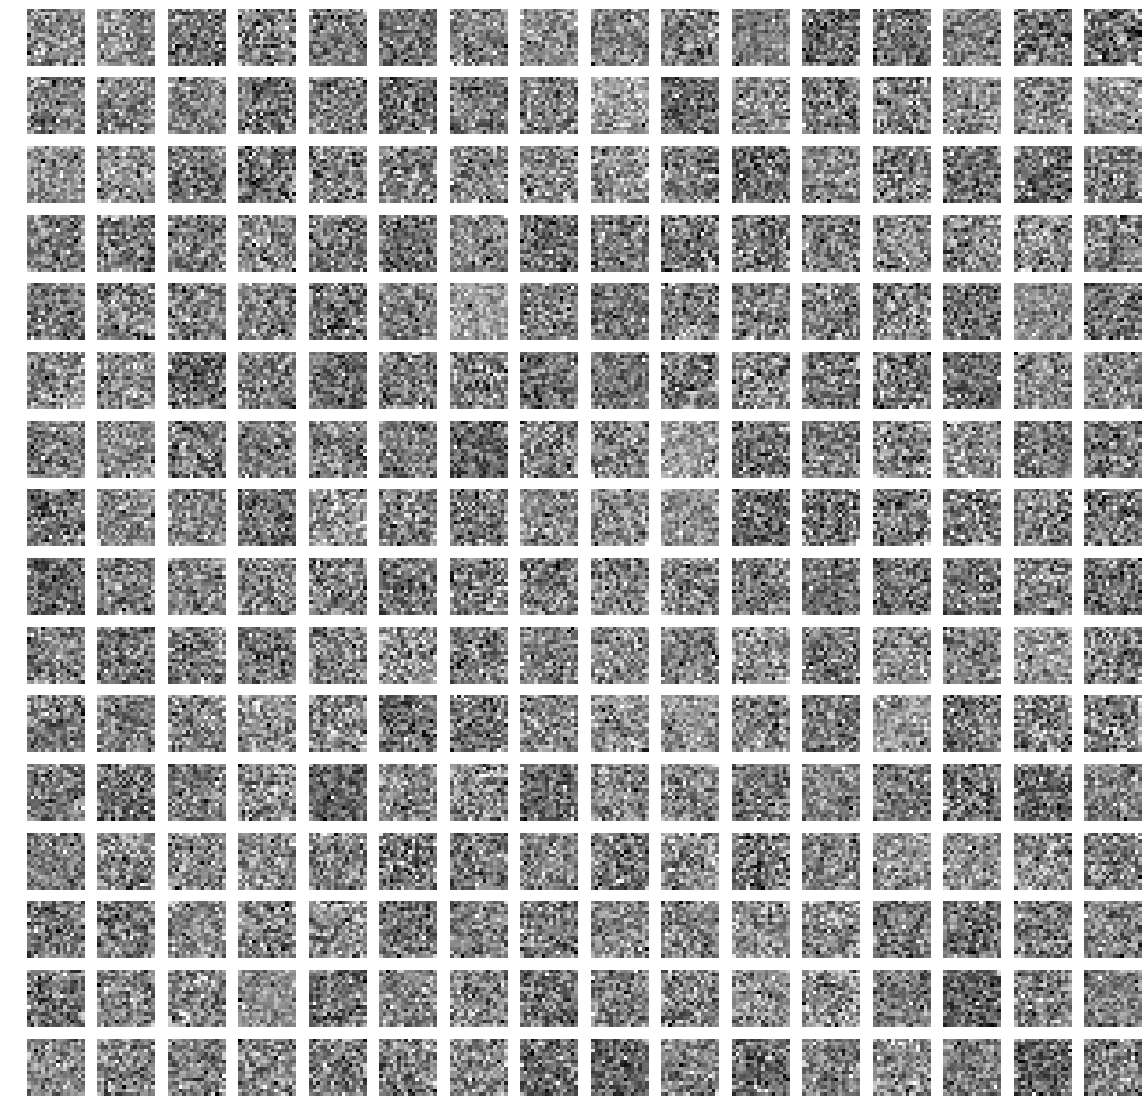

In [148]:
plot_weight(w_synth, -1)

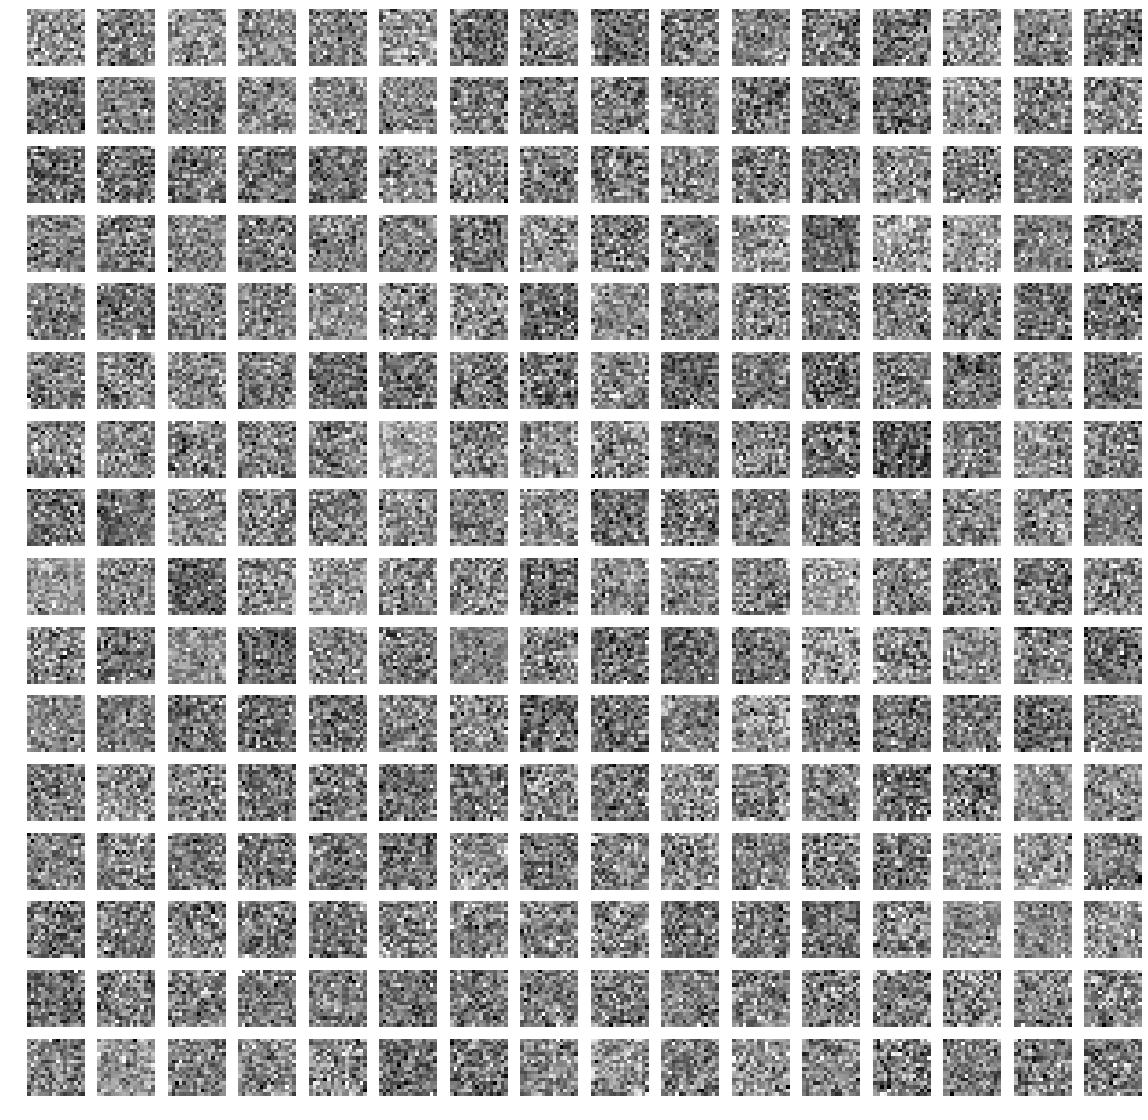

In [149]:
plot_weight(w_analy, 49)